In [1]:
from optparse import OptionParser
import numpy as np
import pandas as pd
import requests
from astropy.io import fits
from astropy.table import Table
from astropy.utils.data import download_file
import shutil
from typing import List, Tuple

import os
from pathlib import Path
import time
import sys
import urllib
from astroquery.sdss import SDSS


def getimages(ra,dec,size=100,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = (f"{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           f"&filters={filters}")
    loc = download_file(url, show_progress=False)
    table = Table.read(loc, format='ascii')
    return table


def geturl(ra, dec, size=100, output_size=None, filters="grizy", format="fits", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url

In [9]:
data = np.load("/cosma/home/durham/dc-will10/spec64new4.npz")
coords = np.load("/cosma/home/durham/dc-will10/spectra/speccoords.npz")
ra = coords["ra"]
dec = coords["dec"]
print(ra[10])
print(dec[10])
urls = geturl(ra[10], dec[10], size=100, filters="grizy", format="fits")

10.7735850723994
13.7237718070854


In [8]:
print(urls[4])

https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=10.7735850723994&dec=13.7237718070854&size=100&format=fits&red=/rings.v3.skycell/1593/048/rings.v3.skycell.1593.048.stk.g.unconv.fits


In [1]:
from __future__ import print_function, division

import sys
from astroML.py3k_compat import HTTPError
import numpy as np
from astroML.datasets import fetch_sdss_spectrum
from astroML.dimensionality import iterative_pca
import pandas as pd
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as units
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from scipy.interpolate import interp1d
import scipy

import os

from astroML.datasets.tools import get_data_home, download_with_progress_bar,\
    SDSSfits, sdss_fits_url, sdss_fits_filename

def fetch_sdss_spectrum1(plate, mjd, fiber, data_home="/cosma5/data/durham/dc-will10/astroMLdata",
                        download_if_missing=True,
                        cache_to_disk=True):
    """Fetch an SDSS spectrum from the Data Archive Server
    Parameters
    ----------
    plate: integer
        plate number of desired spectrum
    mjd: integer
        mean julian date of desired spectrum
    fiber: integer
        fiber number of desired spectrum
    Other Parameters
    ----------------
    data_home: string (optional)
        directory in which to cache downloaded fits files.  If not
        specified, it will be set to ~/astroML_data.
    download_if_missing: boolean (default = True)
        download the fits file if it is not cached locally.
    cache_to_disk: boolean (default = True)
        cache downloaded file to data_home.
    Returns
    -------
    spec: :class:`astroML.tools.SDSSfits` object
        An object wrapper for the fits data
    """
    data_home = get_data_home(data_home)

    target_url = sdss_fits_url(plate, mjd, fiber)
    target_file = os.path.join(data_home, 'SDSSspec', '%04i' % plate,
                               sdss_fits_filename(plate, mjd, fiber))

    if not os.path.exists(target_file):
        if not download_if_missing:
            raise IOError("SDSS colors training data not found")

        buf = download_with_progress_bar(target_url, return_buffer=True)

        if cache_to_disk:
            print("caching to %s" % target_file)
            if not os.path.exists(os.path.dirname(target_file)):
                os.makedirs(os.path.dirname(target_file))
            fhandler = open(target_file, 'wb')
            fhandler.write(buf.read())
            buf.seek(0)
    else:
        buf = target_file

    return SDSSfits(buf), target_file



NameError: name 'wavemin' is not defined

In [15]:
data1 = pd.read_csv("/cosma5/data/durham/dc-will10/FullGalList.csv")
wavemin, wavemax = 3800, 9200
newvpix = 150
npix = np.log10(wavemax/wavemin) / np.log10(1.0 + newvpix/299792.458)
npix = np.int(npix)
newwave = wavemin*(1.0+newvpix/299792.458)**np.arange(npix)
Nlam = len(newwave)

plate = data1["plate"]
mjd = data1["mjd"]
fiber = data1["fiberid"]
ra = data1["ra"]
dec = data1["dec"]
i = np.random.randint(0,len(mjd))
spec, fileext = fetch_sdss_spectrum1(plate[i], mjd[i], fiber[i], data_home="/cosma5/data/durham/dc-will10/astroMLdata")
spec1 = XSpectrum1D.from_file(fileext)
newspec = spec1.rebin(newwave*units.AA,do_sig = True, grow_bad_sig=True)

[========================================]  182.8kb / 182.8kb   
caching to /cosma5/data/durham/dc-will10/astroMLdata/SDSSspec/0658/spSpec-52146-0658-271.fit


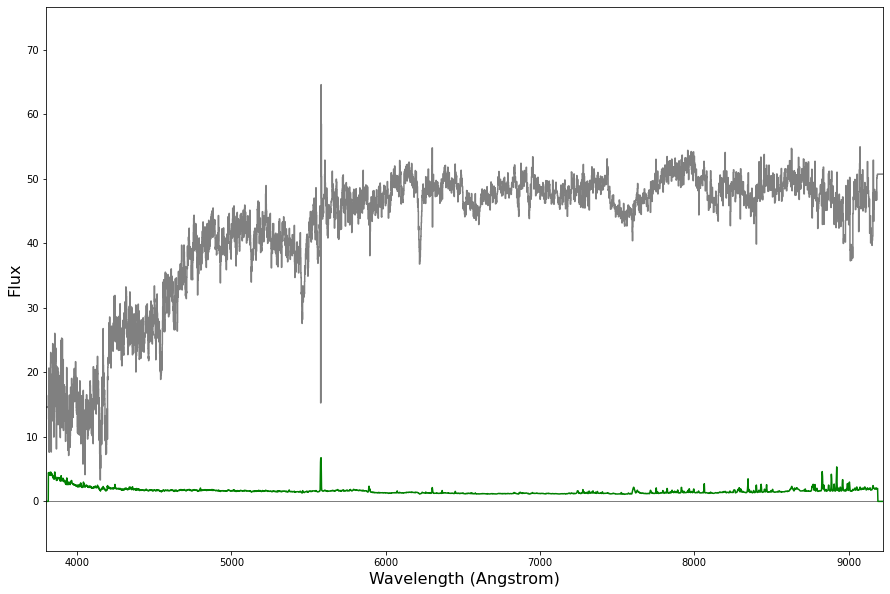

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
spec1.plot()
plt.savefig('/cosma5/data/durham/dc-will10/untouched_spec.eps', format='eps')

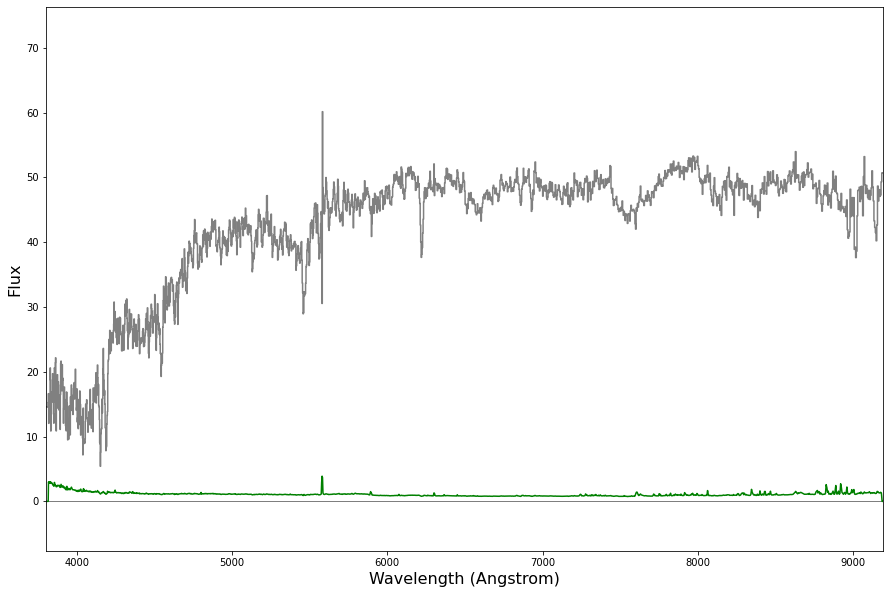

<Figure size 432x288 with 0 Axes>

In [37]:
plt.figure(figsize = (15,10))
newspec.plot()
plt.savefig('/cosma5/data/durham/dc-will10/rebinned_spec.eps', format='eps')

/cosma/home/durham/dc-will10/.local/lib/python3.6/site-packages/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


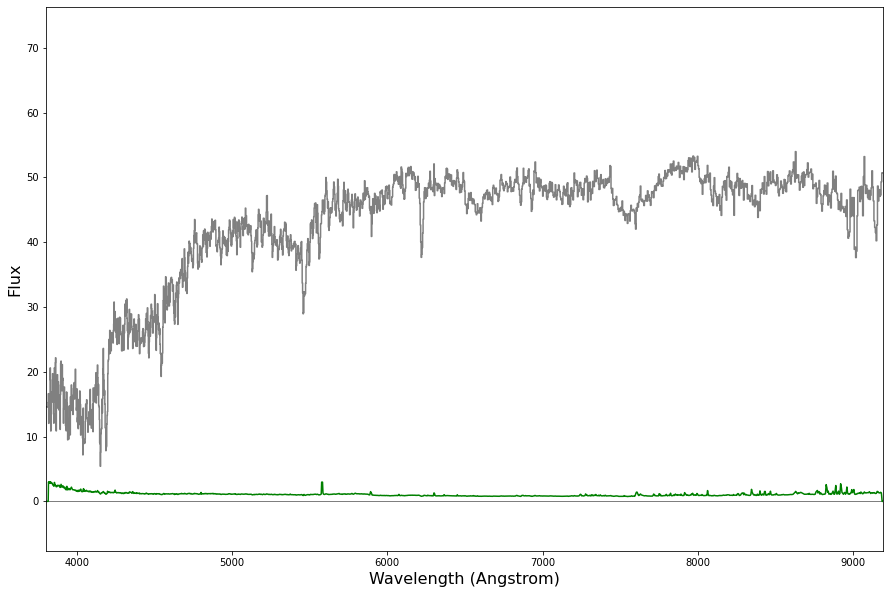

<Figure size 432x288 with 0 Axes>

In [38]:
import scipy
spectra = newspec.flux
specerr = newspec.sig
origspec = spectra
origerrs = specerr
        #testspec = np.delete(spectra[i], [766,767,768,769,770])
        #testerrs = np.delete(specerr[i], [766,767,768,769,770])
        #lmbtest = np.delete(newwave, [766,767,768,769,770])
        #f = interp1d(lmbtest, testspec)
        #g = interp1d(lmbtest, testerrs)
        #origspec = f(newwave)
        #besterrs = g(newwave)
contspec = scipy.ndimage.median_filter(origspec, size=5)
conterrs = scipy.ndimage.median_filter(specerr, size=5)
for n in range(766, 771):
    origspec[n] = contspec[n]
    origerrs[n] = conterrs[n]
mspec = XSpectrum1D(newwave, np.array(origspec), np.array(origerrs))
plt.figure(figsize = (15,10))
mspec.plot()
plt.savefig('/cosma5/data/durham/dc-will10/skyfree_spec.eps', format='eps')

In [27]:
print(ra[i])
print(dec[i])

14.08113504
-9.933478398


In [39]:
flux = (2.99792458*10**-5 * 0.001241639954969287/(6201.2**2))
            #flux2 = (2.99792458*10**-5 * Jy2/(6201.2**2))
            #flux3 = (2.99792458*10**-5 * Jy3/(6201.2**2))
flux /= 10**-17

In [40]:
print(flux)

96.79767044192761


In [41]:
origspec = origspec/flux
origerrs = origerrs/flux

/cosma/home/durham/dc-will10/.local/lib/python3.6/site-packages/linetools/spectra/xspectrum1d.py:253: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


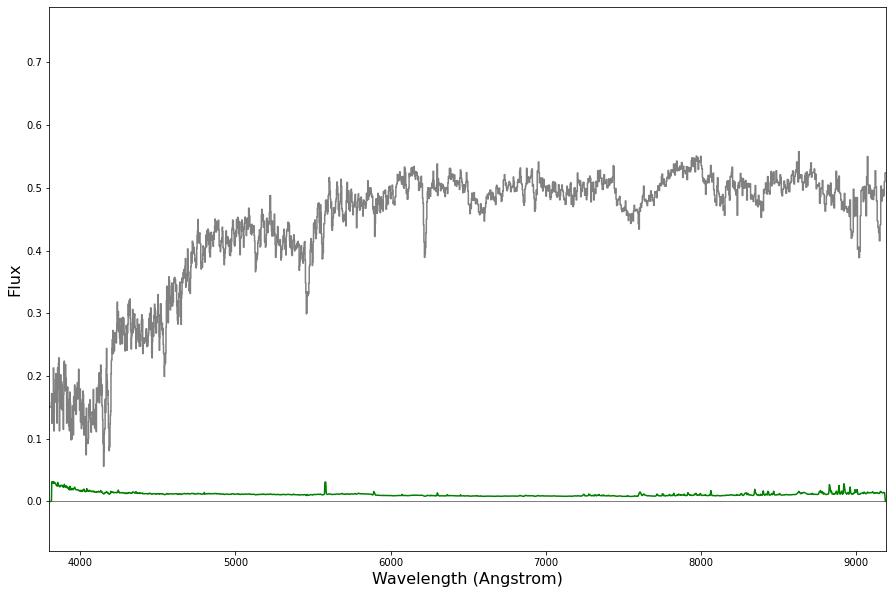

<Figure size 432x288 with 0 Axes>

In [42]:
mspec = XSpectrum1D(newwave, np.array(origspec), np.array(origerrs))
plt.figure(figsize = (15,10))
mspec.plot()
plt.savefig('/cosma5/data/durham/dc-will10/final_spec.eps', format='eps')

In [44]:
len(spec1.flux)

3853